In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import requests
import io
import seaborn as sns
from tqdm.notebook import tqdm
import community as community_louvain
import os
from zipfile import ZipFile
from scipy.stats import fisher_exact
import numpy as np
from statsmodels.stats.multitest import multipletests

In [2]:
def load_biogrid_data(zip_path, organism_id=9606):  # 9606 is the taxonomy ID for Homo sapiens
    """
    Load BioGRID data from a local ZIP file and display key aspects of it.
    
    Parameters:
    zip_path (str): Path to the downloaded BioGRID ZIP file
    organism_id (int): NCBI Taxonomy ID for the organism (default: 9606 for Homo sapiens)
    
    Returns:
    pandas.DataFrame: BioGRID PPI data
    """
    print(f"Loading BioGRID data")
    
    # Open the zip file
    with ZipFile(zip_path) as z:
        # Find all .txt files in the archive
        txt_files = [f for f in z.namelist() if f.endswith('.txt')]
        
        if not txt_files:
            raise Exception("No text files found in the ZIP archive")
        
        # Use the first text file
        data_file = txt_files[0]
        print(f"Using file: {data_file}")
        
        # Read the file
        with z.open(data_file) as f:
            df = pd.read_csv(f, sep='\t', low_memory=False)
        
        # Filter for human PPIs
        human_df = df[(df['Organism Interactor A'] == organism_id) & (df['Organism Interactor B'] == organism_id)]
        print(f"Loaded {human_df.shape[0]} human ppi-interactions")
        #print("Available Columns:")
        #print(df.columns)

    column_name = "Experimental System"
    if column_name not in human_df.columns:
        print(f"Column '{column_name}' not found in the data.")
        print(f"Available columns: {', '.join(human_df.columns)}")
        return {}
    
    # Count experimental systems
    exp_system_counts = human_df[column_name].value_counts().to_dict()
    
    # Get total interactions
    total_interactions = sum(exp_system_counts.values())
    
    # Sort by count
    sorted_systems = sorted(exp_system_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Display table with counts and percentages
    print(f"\nExperimental System Distribution (Total: {total_interactions} interactions):")
    print("-" * 80)
    print(f"{'System Type':<40} | {'Count':>10} | {'Percentage':>10}")
    print("-" * 80)
    
    for system, count in sorted_systems:
        percentage = (count / total_interactions) * 100
        print(f"{system[:40]:<40} | {count:>10,} | {percentage:>9.2f}%")
            
    return human_df

In [3]:
def create_ppi_network(biogrid_df, interaction_type='physical'):
    """
    Create a PPI network from BioGRID data.
    
    Parameters:
    biogrid_df (pandas.DataFrame): BioGRID data
    interaction_type (str): Type of interaction to include ('physical', 'genetic', or 'all')
    
    Returns:
    networkx.Graph: PPI network
    """
    # Create an empty graph as a representation of the PPI network
    G = nx.Graph()
    
    # Filter by interaction type if specified
    if interaction_type == 'physical':
        df_filtered = biogrid_df[biogrid_df['Experimental System Type'] == 'physical']
    elif interaction_type == 'genetic':
        df_filtered = biogrid_df[biogrid_df['Experimental System Type'] == 'genetic']
    else:
        df_filtered = biogrid_df
    
    print(f"Building network with {df_filtered.shape[0]} physical interactions...")

     # Count statistics
    missing_symbols = 0
    self_interactions = 0
    duplicate_edges = 0
    added_edges = 0
    
    # Iterate through the edge dataset
    for _, row in tqdm(df_filtered.iterrows(), total=df_filtered.shape[0]):
        protein_a = row['Official Symbol Interactor A']
        protein_b = row['Official Symbol Interactor B']

        # Check for missing symbols
        if pd.isna(protein_a) or pd.isna(protein_b):
            missing_symbols += 1
            continue
        
        # Skip self-interactions if needed
        if protein_a == protein_b:
            self_interactions += 1
            continue
        
        # Add nodes with attributes
        if not G.has_node(protein_a):
            G.add_node(protein_a, entrez_id=row['Entrez Gene Interactor A']) # Add stable unique identifiers as well
        
        if not G.has_node(protein_b):
            G.add_node(protein_b, entrez_id=row['Entrez Gene Interactor B'])

        # Check if edge already exists
        if G.has_edge(protein_a, protein_b):
            duplicate_edges += 1
        else:
            added_edges += 1
        
        # Add edge with attributes
        if not G.has_edge(protein_a, protein_b):
            G.add_edge(protein_a, protein_b, 
                       exp_system=row['Experimental System'],
                       int_type=row['Experimental System Type'],
                       pubmed_id=row['Pubmed ID'])
        
    print(f"Network created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    print(f"  Interactions with missing symbols: {missing_symbols}")
    print(f"  Self-interactions: {self_interactions}")
    print(f"  Duplicate edges: {duplicate_edges}")
    print(f"  Unique edges added: {added_edges}")
    print(f"  Sum: {added_edges + duplicate_edges + self_interactions + missing_symbols}")
    
    return G

In [4]:
def analyze_network(G):
    """
    Analyze the properties of a PPI network.
    
    Parameters:
    G (networkx.Graph): PPI network
    
    Returns:
    dict: Network properties
    """    
    # Basic properties
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    
    # Calculate network density
    density = nx.density(G)
    
    # Find connected components
    connected_components = list(nx.connected_components(G))
    num_connected_components = len(connected_components)
    
    # Get the largest connected component
    largest_cc = max(connected_components, key=len)
    largest_cc_size = len(largest_cc)
    
    # Create a subgraph of the largest connected component
    G_lcc = G.subgraph(largest_cc).copy()
    
    # Calculate degree distribution
    degree_dict = dict(G.degree())
    degree_values = list(degree_dict.values())
     
    # Top 10 hub proteins (highest degree)
    hub_proteins = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]

    # Count interactions by experimental system
    exp_system_counts = {}
    for u, v, data in G.edges(data=True):
        # Get all values from the Experimental System column with "Unknown" for empty fields
        exp_system = data.get('exp_system', 'Unknown')
        if exp_system in exp_system_counts:
            exp_system_counts[exp_system] += 1
        else:
            exp_system_counts[exp_system] = 1
    # Sort experimental systems by count
    exp_system_counts = {k: v for k, v in sorted(exp_system_counts.items(), 
                                                key=lambda item: item[1], 
                                                reverse=True)}
    
    # Return network properties
    return {
        'num_nodes': num_nodes,
        'num_edges': num_edges,
        'density': density,
        'num_connected_components': num_connected_components,
        'degree_values': degree_values,
        'hub_proteins': hub_proteins,
        'largest_cc_size': largest_cc_size,
        'largest_cc': G_lcc,
        'exp_system_counts': exp_system_counts
    }

#---
def visualize_network_properties(properties):
    """
    Visualize network properties.
    
    Parameters:
    properties (dict): Network properties
    
    Returns:
    None
    """
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    
    # Degree distribution
    axs[0, 0].hist(properties['degree_values'], bins=50, alpha=0.7, color='skyblue')
    axs[0, 0].set_title('Degree Distribution')
    axs[0, 0].set_xlabel('Degree')
    axs[0, 0].set_ylabel('Frequency')
    axs[0, 0].set_yscale('log')
    
    # Top 10 hub proteins
    hub_names = [hub[0] for hub in properties['hub_proteins']]
    hub_degrees = [hub[1] for hub in properties['hub_proteins']]
    
    axs[0, 1].barh(hub_names[::-1], hub_degrees[::-1], color='salmon')
    axs[0, 1].set_title('Top 10 Hub Proteins')
    axs[0, 1].set_xlabel('Degree')
    
    # Network statistics as a table
    stats = {
        'Statistic': ['Number of Nodes', 'Number of Edges', 'Network Density', 
                      'Number of Connected Components', 'Largest CC Size'],
        'Value': [properties['num_nodes'], properties['num_edges'], 
                  f"{properties['density']:.6f}", properties['num_connected_components'], 
                  properties['largest_cc_size']]
    }
    
    axs[1, 0].axis('off')
    table = axs[1, 0].table(cellText=list(zip(stats['Statistic'], stats['Value'])),
                          loc='center', cellLoc='left', colWidths=[0.6, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)

    # Experimental System Distribution
    if 'exp_system_counts' in properties:
        # Get the top 10 experimental systems
        sorted_systems = sorted(properties['exp_system_counts'].items(), 
                               key=lambda x: x[1], 
                               reverse=True)[:10]
        
        if sorted_systems:
            systems = [s[0] for s in sorted_systems]
            counts = [s[1] for s in sorted_systems]
            
            # Create a simple bar chart
            y_pos = range(len(systems))
            axs[1, 1].barh(y_pos, counts, color='lightgreen')
            axs[1, 1].set_yticks(y_pos)
            axs[1, 1].set_yticklabels(systems)
            axs[1, 1].set_title('Top 10 Experimental Systems')
            axs[1, 1].set_xlabel('Number of Interactions')
    else:
        axs[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

In [5]:
def visualize_network(G, layout='spring', node_size_factor=10, max_nodes=500):
    """
    Visualize a PPI network.
    
    Parameters:
    G (networkx.Graph): PPI network
    layout (str): Layout algorithm ('spring', 'circular', 'kamada_kawai', 'spectral')
    node_size_factor (int): Factor to scale node sizes by degree
    max_nodes (int): Maximum number of nodes to visualize
    
    Returns:
    None
    """
    # If the network is too large, take a subgraph based on the nodes with the most degrees
    if G.number_of_nodes() > max_nodes:
        print(f"Network is too large ({G.number_of_nodes()} nodes). Visualizing a subgraph of {max_nodes} nodes with highest degrees...")
        # Get the nodes with highest degree
        node_degrees = dict(G.degree())
        top_nodes = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)[:max_nodes]
        top_node_names = [node for node, _ in top_nodes]
        G_vis = G.subgraph(top_node_names).copy()
    else:
        G_vis = G
    
    # Create figure
    plt.figure(figsize=(12, 12))
    
    # Choose layout
    if layout == 'spring':
        pos = nx.spring_layout(G_vis, seed=42)
    elif layout == 'circular':
        pos = nx.circular_layout(G_vis)
    elif layout == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(G_vis)
    elif layout == 'spectral':
        pos = nx.spectral_layout(G_vis)
    else:
        pos = nx.spring_layout(G_vis, seed=42)
    
    # Get node degrees for sizing
    node_degrees = dict(G_vis.degree())
    node_sizes = [node_size_factor * (degree + 1) for node, degree in node_degrees.items()]
    
    # Draw nodes
    nx.draw_networkx_nodes(G_vis, pos, node_size=node_sizes, node_color='lightblue', alpha=0.8)
    
    # Draw edges
    nx.draw_networkx_edges(G_vis, pos, width=0.5, alpha=0.5)
    
    # Draw labels for high-degree nodes
    high_degree_nodes = {node: node for node, degree in node_degrees.items() if degree > np.percentile(list(node_degrees.values()), 95)}
    nx.draw_networkx_labels(G_vis, pos, labels=high_degree_nodes, font_size=10, font_weight='bold')
    
    plt.title(f'Human PPI Network ({G_vis.number_of_nodes()} proteins, {G_vis.number_of_edges()} interactions)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

#---
def visualize_network_with_highlights(G, csv_file="genes_groups_26_27.csv", 
                                    gene_column = "Gene", layout='spring', 
                                    node_size_factor=10, max_nodes=500, 
                                    highlight_color='red', regular_color='lightblue'):
    """
    Visualize a PPI network with highlighted genes.
    
    Parameters:
    G (networkx.Graph): PPI network
    layout (str): Layout algorithm ('spring', 'circular', 'kamada_kawai', 'spectral')
    node_size_factor (int): Factor to scale node sizes by degree
    max_nodes (int): Maximum number of nodes to visualize
    highlight_color (str): Color for highlighted genes
    regular_color (str): Color for regular genes
    
    Returns:
    None
    """
    # Read the CSV file
    df = pd.read_csv(csv_file)
    
    # Check if the gene column exists
    if gene_column not in df.columns:
        print(f"Column '{gene_column}' not found in the CSV file.")
        print(f"Available columns: {', '.join(df.columns)}")
        return set()
    
    # Extract gene symbols and convert to a set
    highlight_genes = set(df[gene_column].dropna().unique())
    
    print(f"Loaded {len(highlight_genes)} unique genes from {csv_file}")

    # If no genes to highlight, use regular visualization
    if highlight_genes is None or len(highlight_genes) == 0:
        visualize_network(G, layout, node_size_factor, max_nodes)
        return
    
    # Filter network to include highlighted genes and their neighbors
    highlight_genes_in_network = set(highlight_genes).intersection(set(G.nodes()))
    
    print(f"Found {len(highlight_genes_in_network)} of {len(highlight_genes)} genes in the network")
    
    # If network is too large, take a subgraph focused on highlighted genes
    if G.number_of_nodes() > max_nodes:
        # First include all highlighted genes
        included_nodes = set(highlight_genes_in_network)
        
        # Then add neighbors of highlighted genes
        for gene in highlight_genes_in_network:
            included_nodes.update(G.neighbors(gene))
        
        # Add highest degree nodes not already included
        remaining_slots = max_nodes - len(included_nodes)
        if remaining_slots > 0:
            # Get nodes not already included, sorted by degree
            node_degrees = dict(G.degree())
            remaining_nodes = [(node, degree) for node, degree in node_degrees.items() 
                              if node not in included_nodes]
            top_remaining = sorted(remaining_nodes, key=lambda x: x[1], reverse=True)[:remaining_slots]
            # Add these high-degree nodes
            included_nodes.update([node for node, _ in top_remaining])
        
        # Create the subgraph
        G_vis = G.subgraph(included_nodes).copy()
        print(f"Created subgraph with {G_vis.number_of_nodes()} nodes and {G_vis.number_of_edges()} edges")
    else:
        G_vis = G
    
    # Create figure
    plt.figure(figsize=(14, 14))
    
    # Choose layout
    if layout == 'spring':
        pos = nx.spring_layout(G_vis, seed=42)
    elif layout == 'circular':
        pos = nx.circular_layout(G_vis)
    elif layout == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(G_vis)
    elif layout == 'spectral':
        pos = nx.spectral_layout(G_vis)
    else:
        pos = nx.spring_layout(G_vis, seed=42)
    
    # Get node degrees for sizing
    node_degrees = dict(G_vis.degree())
    
    # Create node lists and sizes for highlighted and regular nodes
    highlighted_nodes = [node for node in G_vis.nodes() if node in highlight_genes]
    regular_nodes = [node for node in G_vis.nodes() if node not in highlight_genes]
    
    highlighted_sizes = [node_size_factor * (node_degrees[node] + 1) * 1.5 for node in highlighted_nodes]
    regular_sizes = [node_size_factor * (node_degrees[node] + 1) for node in regular_nodes]
    
    # Draw regular nodes
    nx.draw_networkx_nodes(G_vis, pos, nodelist=regular_nodes, 
                          node_size=regular_sizes, node_color=regular_color, alpha=0.7)
    
    # Draw highlighted nodes
    if highlighted_nodes:
        nx.draw_networkx_nodes(G_vis, pos, nodelist=highlighted_nodes, 
                              node_size=highlighted_sizes, node_color=highlight_color, alpha=0.9)
    
    # Draw edges
    nx.draw_networkx_edges(G_vis, pos, width=0.5, alpha=0.5)
    
    # Label all highlighted nodes
    highlighted_labels = {node: node for node in highlighted_nodes}
    nx.draw_networkx_labels(G_vis, pos, labels=highlighted_labels, 
                           font_size=10, font_weight='bold')
    
    # Title and layout
    plt.title(f'PPI Network with Disease Genes ({len(highlighted_nodes)} genes highlighted)')
    plt.axis('off')
    plt.tight_layout()    
    plt.show()
    
    # Also create a subnetwork of just the highlighted genes and their direct neighbors
    if len(highlighted_nodes) > 0:
        highlight_subnetwork = G.subgraph(highlighted_nodes).copy() # Includes all edges that connect pairs of nodes
        
        if highlight_subnetwork.number_of_edges() > 0:
            plt.figure(figsize=(12, 12))
            plt.title(f"Interactions Between Disease Genes ({highlight_subnetwork.number_of_edges()} interactions)")
            
            # Use a different layout for clarity
            pos = nx.spring_layout(highlight_subnetwork, seed=42)
            
            node_sizes = [node_size_factor * 5 * (dict(highlight_subnetwork.degree())[node] + 1) 
                         for node in highlight_subnetwork.nodes()]
            
            nx.draw_networkx_nodes(highlight_subnetwork, pos, node_size=node_sizes, 
                                  node_color=highlight_color, alpha=0.9)
            nx.draw_networkx_edges(highlight_subnetwork, pos, width=1.0, alpha=0.7)
            nx.draw_networkx_labels(highlight_subnetwork, pos, font_size=10, font_weight='bold')
            
            plt.axis('off')
            plt.tight_layout()
            plt.show()
        else:
            print("No direct interactions found between highlighted genes")

In [6]:
def analyze_gene_set_connectivity(G, gene_set_file="genes_groups_26_27.csv", gene_column="Gene"):
    """
    Analyze the connectivity of genes in a specified gene set within the PPI network.
    
    Parameters:
    G (networkx.Graph): PPI network
    gene_set_file (str): Path to CSV file containing genes of interest
    gene_column (str): Column name in CSV containing gene symbols
    
    Returns:
    pandas.DataFrame: Connectivity metrics for each gene
    """
    df = pd.read_csv(gene_set_file)
    
    # Check if the gene column exists
    if gene_column not in df.columns:
        print(f"Column '{gene_column}' not found in the CSV file.")
        print(f"Available columns: {', '.join(df.columns)}")
        return None
    
    # Extract gene symbols and convert to a set
    genes = set(df[gene_column].dropna().unique())
    print(f"Analyzing connectivity for {len(genes)} unique genes from {gene_set_file}")
    
    # Find genes that are present in the network
    genes_in_network = genes.intersection(set(G.nodes()))
    print(f"Found {len(genes_in_network)} of {len(genes)} genes in the network")
    
    # Initialize results list
    results = []
    
    # For each gene in the network, calculate connectivity metrics
    for gene in genes_in_network:
        # Get direct neighbors
        neighbors = set(G.neighbors(gene))
        # Calculate metrics
        degree = G.degree(gene)
        genes_connected_to = len(neighbors.intersection(genes_in_network))
        # Add to results
        results.append({
            'Gene': gene,
            'Degree': degree,
            'Connected_Genes_In_Network': genes_connected_to,
            'Connected_Genes_Names': ','.join(sorted(neighbors.intersection(genes_in_network))),
        })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    # Sort by degree
    results_df = results_df.sort_values('Degree', ascending=False)
    
    # Genes not in network
    missing_genes = genes - genes_in_network
    if missing_genes:
        print(f"Genes not found in the network ({len(missing_genes)}):")
        print(', '.join(sorted(missing_genes)))
    
    return results_df

#---
def visualize_gene_set_connectivity(connectivity_df, G, top_n=20):
    """
    Visualize connectivity metrics for genes in the gene set.
    
    Parameters:
    connectivity_df (pandas.DataFrame): DataFrame from analyze_gene_set_connectivity
    G (networkx.Graph): Original PPI network
    top_n (int): Number of top genes to show in the bar charts
    
    Returns:
    None
    """
    if connectivity_df is None or connectivity_df.empty:
        print("No connectivity data to visualize.")
        return
    
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))
    
    # 1. Top genes by degree
    top_degree = connectivity_df.head(min(top_n, len(connectivity_df)))
    axs[0].barh(top_degree['Gene'][::-1], top_degree['Degree'][::-1], color='skyblue')
    axs[0].set_title(f'Top {len(top_degree)} Genes by Degree')
    axs[0].set_xlabel('Degree (Number of Connections)')
    
    # 2. Top genes by connections to other genes in the set
    top_set_connections = connectivity_df.sort_values('Connected_Genes_In_Network', ascending=False).head(min(top_n, len(connectivity_df)))
    axs[1].barh(top_set_connections['Gene'][::-1], top_set_connections['Connected_Genes_In_Network'][::-1], color='salmon')
    axs[1].set_title(f'Top {len(top_set_connections)} Genes by Connections Within Gene Set')
    axs[1].set_xlabel('Number of Connections to Other Genes in Set')
    
    plt.tight_layout()
    plt.show()

In [7]:
def detect_global_communities_and_analyze_gene_set(G, gene_set_file="genes_groups_26_27.csv", gene_column="Gene"):
    """
    Detect communities in the whole PPI network and analyze how genes from a gene set
    are distributed across these communities.
    
    Parameters:
    G (networkx.Graph): Full PPI network
    gene_set_file (str): Path to CSV file containing genes of interest
    gene_column (str): Column name in CSV containing gene symbols
    
    Returns:
    tuple: (communities, community_stats, gene_distribution)
        - communities: List of sets, each containing genes in a community
        - community_stats: DataFrame with community statistics
        - gene_distribution: DataFrame showing distribution of genes across communities
    """
    # Load gene set
    try:
        df = pd.read_csv(gene_set_file)
    except FileNotFoundError:
        print(f"Gene set file {gene_set_file} not found.")
        return None, None, None
    
    # Check if the gene column exists
    if gene_column not in df.columns:
        print(f"Column '{gene_column}' not found in the CSV file.")
        print(f"Available columns: {', '.join(df.columns)}")
        return None, None, None
    
    # Extract gene symbols and convert to a set
    genes_of_interest = set(df[gene_column].dropna().unique())
    genes_in_network = genes_of_interest.intersection(set(G.nodes()))
    
    print(f"Loaded {len(genes_of_interest)} genes from {gene_set_file}")
    print(f"Found {len(genes_in_network)} of these genes in the network")
    
    # First, detect communities in the whole network
    print("Detecting communities in the entire PPI network...")
    
    # Run community detection
    # How it works: 
    # Louvain algorithm optimizes modularity by iteratively moving nodes between communities
    # and merging communities until no improvement in modularity is possible
    # Output: Produces a single partition of the network into non-overlapping communities
    communities = list(nx.algorithms.community.louvain_communities(G))
    partition = {}
    for i, community in enumerate(communities):
        for node in community:
            partition[node] = i
    
    # Convert partition to a list of communities
    communities_dict = {}
    for node, community_id in partition.items():
        if community_id not in communities_dict:
            communities_dict[community_id] = set()
        communities_dict[community_id].add(node)
    
    # Convert to list of sets, sorted by size
    community_list = [community for community in communities_dict.values()]
    community_list.sort(key=len, reverse=True)
    
    print(f"Detected {len(community_list)} communities in the PPI network")
    
    # Create a reverse mapping from node to community ID
    node_to_community = {}
    for i, community in enumerate(community_list):
        for node in community:
            node_to_community[node] = i
    
    # Create statistics about communities
    community_stats = []
    for i, community in enumerate(community_list):
        size = len(community)
        # Find genes of interest in this community
        genes_in_community = community.intersection(genes_in_network)
        community_stats.append({
            'Community_ID': i,
            'Size': size,
            'Genes_Of_Interest': len(genes_in_community),
            'Percentage_Of_Community': (len(genes_in_community) / size) * 100 if size > 0 else 0,
            'Percentage_Of_Gene_Set': (len(genes_in_community) / len(genes_in_network)) * 100 if len(genes_in_network) > 0 else 0
        })
    
    # Convert to DataFrame
    stats_df = pd.DataFrame(community_stats)
    
    # Total nodes in network
    total_nodes = G.number_of_nodes()
    # Total genes of interest in network
    total_genes_of_interest = len(genes_in_network)
    
    # Calculate Fisher's exact test for the gene set and each community separately
    # This tests whether genes from the gene set are statistically overrepresented in the community
    p_values = []
    odds_ratios = []
    
    for _, row in stats_df.iterrows():
        # Build contingency table
        a = row['Genes_Of_Interest']  # Genes of interest in community
        b = row['Size'] - a  # Other genes in community
        c = total_genes_of_interest - a  # Genes of interest outside community
        d = total_nodes - total_genes_of_interest - b  # Other genes outside community
        
        # Skip communities with no genes of interest
        if a == 0:
            p_values.append(1.0)
            odds_ratios.append(0.0)
            continue
        
        table = np.array([[a, b], [c, d]])
        # Test for overrepresentation specifically 
        # => Calculate the p-value only for greater values that are equally or more extreme
        odds_ratio, p_value = fisher_exact(table, alternative='greater')
        p_values.append(p_value)
        odds_ratios.append(odds_ratio)
    
    # Add to DataFrame
    stats_df['Enrichment_P_Value'] = p_values
    stats_df['Odds_Ratio'] = odds_ratios # Measures the strength of the relationship between gene set and community
    
    # Apply Benjamini-Hochberg correction
    if len(p_values) > 0:
        _, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')
        stats_df['Adjusted_P_Value'] = corrected_p_values
    
    # Sort by enrichment
    stats_df = stats_df.sort_values('Adjusted_P_Value')
    
    # Create a mapping of genes to their communities
    gene_to_community_mapping = {}
    for gene in genes_in_network:
        community_id = node_to_community.get(gene)
        if community_id is not None:
            gene_to_community_mapping[gene] = community_id
    
    # Create a gene distribution DataFrame
    gene_distribution = []
    for gene in genes_in_network:
        community_id = gene_to_community_mapping.get(gene)
        if community_id is not None:
            # Get community size by accessing stat_df
            community_size = next((row['Size'] for i, row in stats_df.iterrows() 
                                 if row['Community_ID'] == community_id), 0)
            # Get community enrichment (so the p-value for the gene set) from stats_df
            community_pvalue = next((row['Adjusted_P_Value'] for i, row in stats_df.iterrows() 
                                   if row['Community_ID'] == community_id), 1.0)
            gene_distribution.append({
                'Gene': gene,
                'Community_ID': community_id,
                'Community_Size': community_size,
                'Community_Enrichment_p_value': community_pvalue
            })
    
    # Convert to DataFrame
    gene_dist_df = pd.DataFrame(gene_distribution)
    # Sort by community ID
    gene_dist_df = gene_dist_df.sort_values(['Community_Enrichment_p_value', 'Community_ID', 'Gene'])
    
    # Identify significantly enriched communities
    enriched_communities = stats_df[stats_df['Adjusted_P_Value'] < 0.05]['Community_ID'].tolist()
    print(f"Found {len(enriched_communities)} significantly enriched communities")
    
    return community_list, stats_df, gene_dist_df

In [8]:
import requests
import json
import pandas as pd
import time
from typing import List, Dict, Optional

def pathway_enrichment_analysis(gene_set_file: str, 
                               gene_column: str = "Gene",
                               databases: List[str] = None,
                               p_value_threshold: float = 0.05) -> pd.DataFrame:
    """
    Perform pathway enrichment analysis using Enrichr API for a gene set.
    Test whether the specified gene set appears in any biological pathway more often than would be expected by random chance.
    
    Parameters:
    gene_set_file (str): Path to CSV file containing genes of interest
    gene_column (str): Column name in CSV containing gene symbols
    databases (List[str]): List of pathway databases to query
    p_value_threshold (float): Significance threshold for pathways
    
    Returns:
    pd.DataFrame: DataFrame with enriched pathways and statistics
    """
    
    # Default databases if none specified
    if databases is None:
        databases = [
            'KEGG_2021_Human',            # Metabolic and signaling pathways
            'Reactome_2022',              # Detailed biological pathways  
            'GO_Biological_Process_2023', # Gene Ontology processes
            'GO_Molecular_Function_2023', # Gene Ontology functions
            'WikiPathways_2023_Human',    # Community-curated pathways
            'MSigDB_Hallmark_2020'        # Cancer hallmark gene sets
        ]
    
    # Load gene set
    df = pd.read_csv(gene_set_file)
    
    # Check if the gene column exists
    if gene_column not in df.columns:
        print(f"Column '{gene_column}' not found in the CSV file.")
        print(f"Available columns: {', '.join(df.columns)}")
        return pd.DataFrame()
    
    # Extract gene list
    gene_list = df[gene_column].dropna().unique().tolist()
    print(f"Analyzing {len(gene_list)} genes for pathway enrichment")
    
    # Submit gene list to Enrichr
    # Enrichr is a web-tool for gene enrichment analysis based on hypergeometric tests:
    # - Population: All genes in the genome
    # - Sample: Your input gene list  
    # - Successes in population: Genes in the pathway/term
    # - Successes in sample: Overlap between your genes and pathway
    genes_str = '\n'.join(gene_list)
    payload = {
        'list': (None, genes_str),
        'description': (None, 'Gene set pathway analysis')
    }   
    try:
        response = requests.post('https://maayanlab.cloud/Enrichr/addList', 
                               files=payload)
        if response.status_code != 200:
            print(f"Error submitting gene list: {response.status_code}")
            return pd.DataFrame()
        # Get back a user list that identifies the gene list submission
        user_list_id = json.loads(response.text)['userListId']
        print(f"Gene list submitted successfully to Enrichr. List ID: {user_list_id}")
        
    except Exception as e:
        print(f"Error submitting gene list: {e}")
        return pd.DataFrame()
    
    # Collect results from all databases
    all_results = []
    
    for database in databases:
        print(f"Querying {database}...")
        try:
            # Get enrichment results
            enrichr_url = f'https://maayanlab.cloud/Enrichr/enrich'
            params = {
                'userListId': user_list_id,
                'backgroundType': database
            }
            
            response = requests.get(enrichr_url, params=params)
            if response.status_code != 200:
                print(f"Error querying {database}: {response.status_code}")
                continue
            results = json.loads(response.text)
            
            # Process results
            # Results contain pathway information underneath a block that specifies the database
            if database in results:
                for pathway_data in results[database]:
                    # Extract pathway information
                    pathway_name = pathway_data[1]
                    p_value = pathway_data[2]
                    adjusted_p_value = pathway_data[6]
                    odds_ratio = pathway_data[3]
                    combined_score = pathway_data[4]
                    genes_in_pathway = pathway_data[5]
                    # Only include significant pathways
                    if adjusted_p_value <= p_value_threshold:
                        all_results.append({
                            'Database': database,
                            'Pathway': pathway_name,
                            'P_Value': p_value,
                            'Adjusted_P_Value': adjusted_p_value, # Accounts for testing gene set against every pathway in the database
                            'Odds_Ratio': odds_ratio,
                            'Combined_Score': combined_score,
                            'Genes_In_Pathway': len(genes_in_pathway),
                            'Gene_List': ';'.join(genes_in_pathway)
                        })
                        
            # Be respectful to the API
            time.sleep(0.5)
            
        except Exception as e:
            print(f"Error processing {database}: {e}")
            continue
    
    # Convert to DataFrame
    results_df = pd.DataFrame(all_results)
    
    return results_df

#---
def summarize_pathway_results(results_df: pd.DataFrame) -> None:
    """
    Print a summary of pathway enrichment results by database.
    
    Parameters:
    results_df (pd.DataFrame): Results from pathway_enrichment_analysis
    """
    if len(results_df) == 0:
        print("No results to summarize.")
        return
    
    # Summary by database
    summary = results_df.groupby('Database').agg({
        'Pathway': 'count',
        'Adjusted_P_Value': 'min',
        'Odds_Ratio': 'max'
    }).round(4)

    # Summary by pathways
    summary.columns = ['Enriched_Pathways', 'Best_P_Value', 'Max_Odds_Ratio']
    print("\nResults by Database:")
    print(summary.to_string())
    # Most significant pathways across all databases
    print(f"\nTop 5 Most Significant Pathways (any database):")
    top_pathways = results_df.nsmallest(5, 'Adjusted_P_Value') # Get the entries (pathway information) whith lowest p-values
    display_cols = ['Database', 'Pathway', 'Adjusted_P_Value', 'Odds_Ratio']
    print(top_pathways[display_cols].to_string(index=False))

Loading BioGRID data
Using file: BIOGRID-MV-Physical-4.4.245.tab2.txt
Loaded 318015 human ppi-interactions

Experimental System Distribution (Total: 318015 interactions):
--------------------------------------------------------------------------------
System Type                              |      Count | Percentage
--------------------------------------------------------------------------------
Affinity Capture-MS                      |    124,227 |     39.06%
Affinity Capture-Western                 |     61,914 |     19.47%
Proximity Label-MS                       |     28,720 |      9.03%
Reconstituted Complex                    |     27,385 |      8.61%
Co-fractionation                         |     22,161 |      6.97%
Two-hybrid                               |     21,778 |      6.85%
Biochemical Activity                     |      9,542 |      3.00%
Cross-Linking-MS (XL-MS)                 |      8,267 |      2.60%
Co-localization                          |      3,648 |      1.1

,#BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Systematic Name Interactor A,Systematic Name Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Synonyms Interactor A,...,Pubmed ID,Organism Interactor A,Organism Interactor B,Throughput,Score,Modification,Phenotypes,Qualifications,Tags,Source Database
0,103,6416,2318,112315,108607,-,-,MAP2K4,FLNC,JNKK|JNKK1|MAPKK4|MEK4|MKK4|PRKMK4|SAPKK-1|SAP...,...,9006895,9606,9606,Low Throughput,-,-,-,-,-,BIOGRID
1,278,2624,5371,108894,111384,-,-,GATA2,PML,DCML|IMD21|MONOMAC|NFE1B,...,10938104,9606,9606,Low Throughput,-,-,-,-,-,BIOGRID
2,418,6118,6774,112038,112651,RP4-547C9.3,-,RPA2,STAT3,REPA2|RP-A p32|RP-A p34|RPA32,...,10875894,9606,9606,Low Throughput,-,-,-,-,-,BIOGRID
3,586,375,23163,106870,116775,-,-,ARF1,GGA3,-,...,10747089,9606,9606,Low Throughput,-,-,-,-,-,BIOGRID
4,612,377,23647,106872,117174,-,-,ARF3,ARFIP2,-,...,9038142,9606,9606,Low Throughput,-,-,-,-,-,BIOGRID


Building network with 318015 physical interactions...


  0%|          | 0/318015 [00:00<?, ?it/s]

Network created with 11553 nodes and 89993 edges
  Interactions with missing symbols: 0
  Self-interactions: 5931
  Duplicate edges: 222091
  Unique edges added: 89993
  Sum: 318015


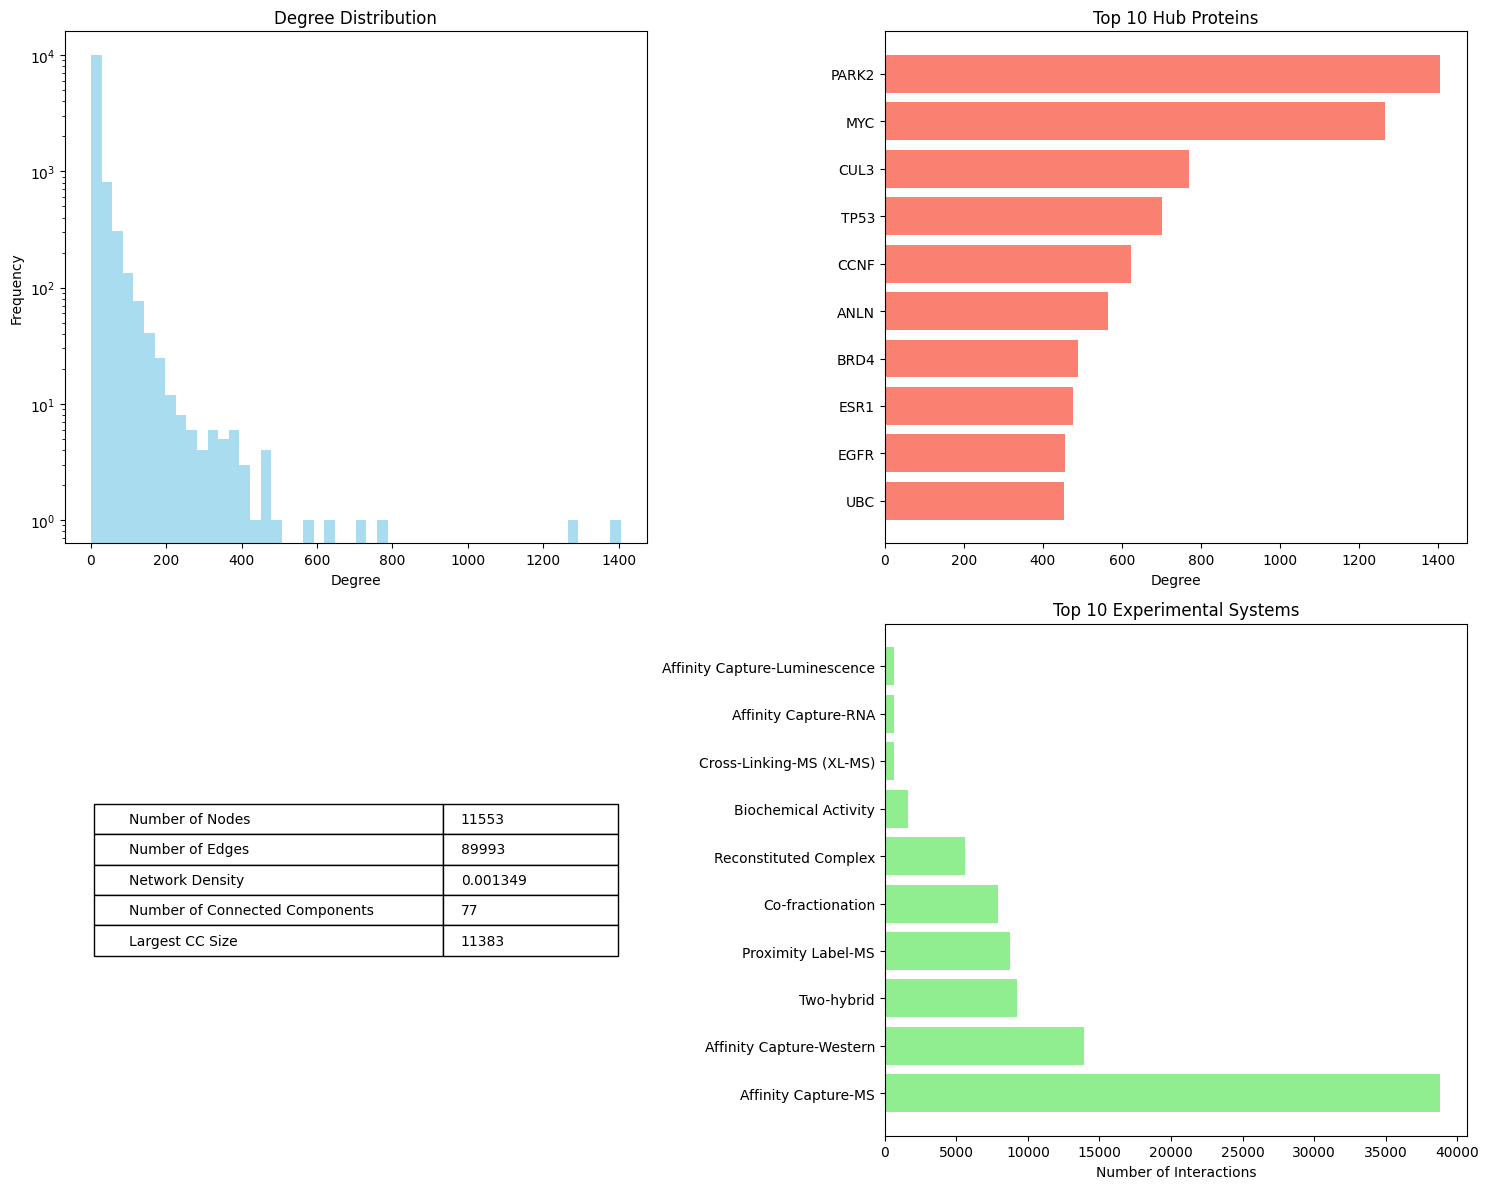

Network is too large (11383 nodes). Visualizing a subgraph of 300 nodes with highest degrees...


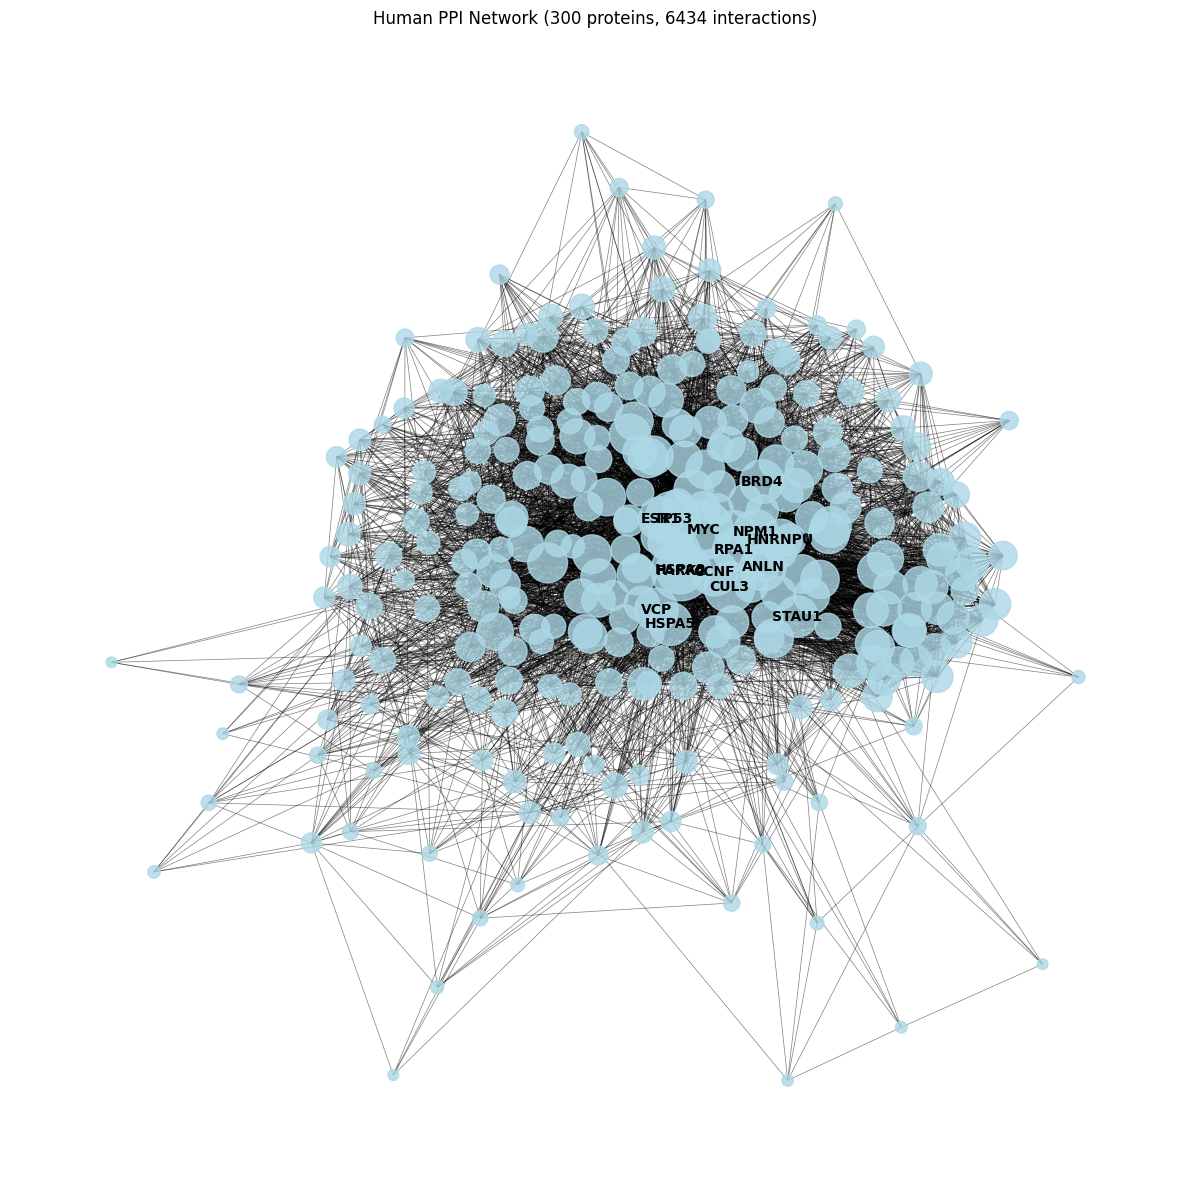

Loaded 58 unique genes from genes_groups_26_27.csv
Found 40 of 58 genes in the network
Created subgraph with 688 nodes and 5721 edges


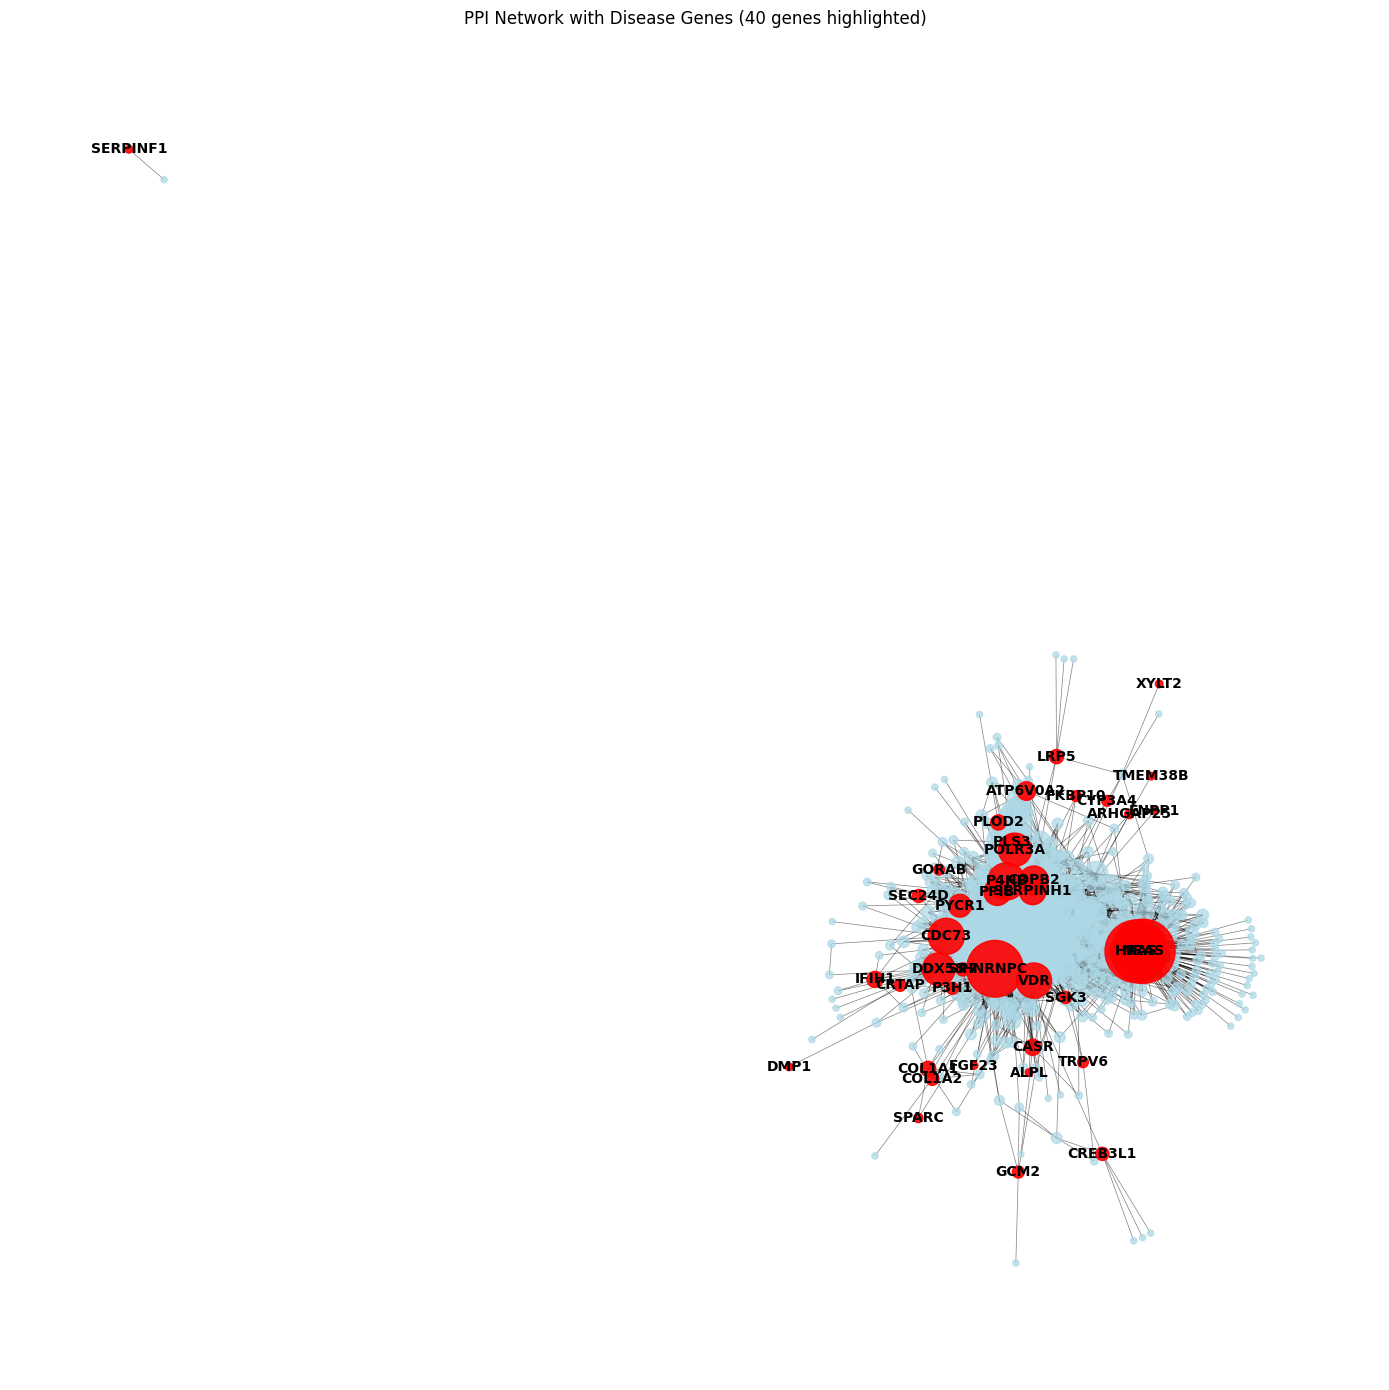

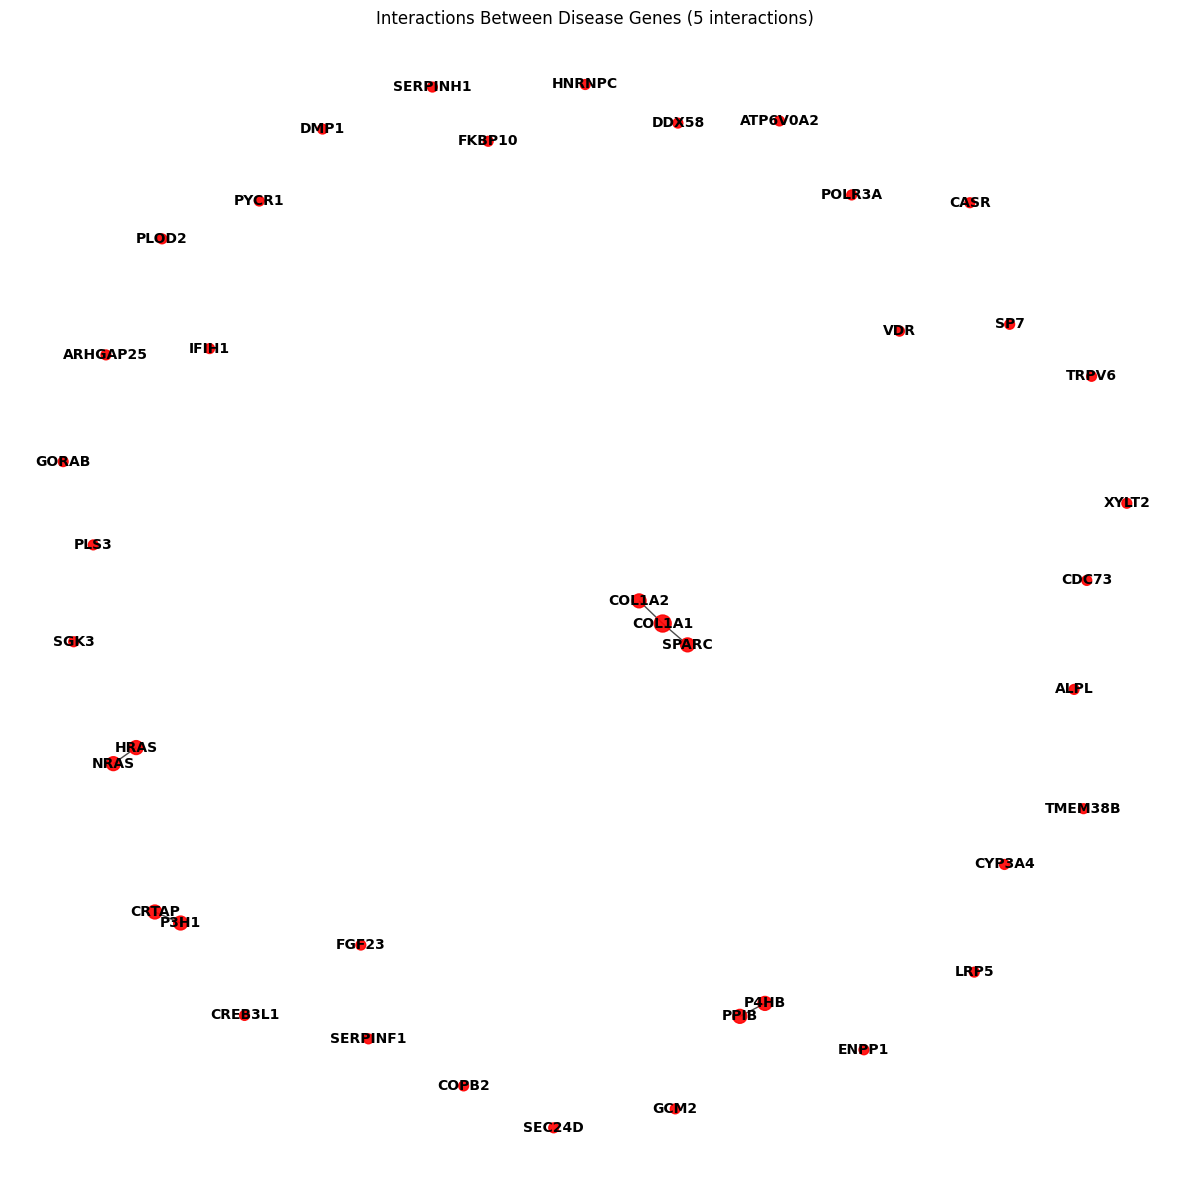

Analyzing connectivity for 58 unique genes from genes_groups_26_27.csv
Found 40 of 58 genes in the network
Genes not found in the network (18):
2p14‐p13.3, ANKH, ANO5, BMP1, CCD134, CLCN5, CYP27B1, CYP2R1, IFITM5, KDELR2, MBTPS2, MESD, PHEX, SGMS2, SLC34A3, TENT5A, TNFRSF11B, WNT1


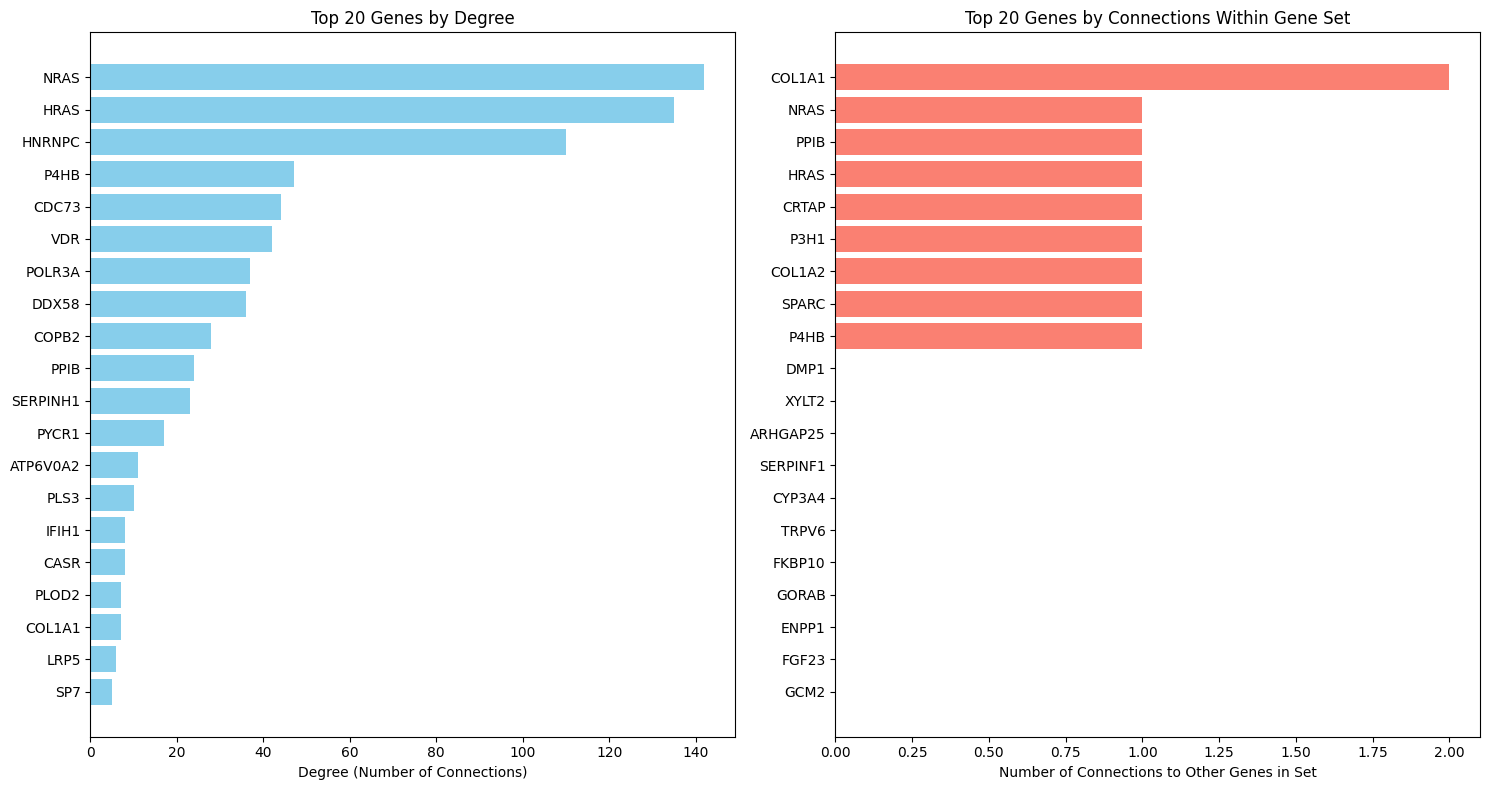

Loaded 58 genes from genes_groups_26_27.csv
Found 40 of these genes in the network
Detecting communities in the entire PPI network...
Detected 103 communities in the PPI network
Found 0 significantly enriched communities

Top Communities Enriched for Genes of Interest:


,Community_ID,Size,Genes_Of_Interest,Percentage_Of_Community,Percentage_Of_Gene_Set,Adjusted_P_Value
0,0,2520,9,0.357143,22.5,1.0
13,13,137,1,0.729927,2.5,1.0
8,8,622,6,0.964630,15.0,1.0
7,7,660,1,0.151515,2.5,1.0
6,6,679,3,0.441826,7.5,1.0
4,4,809,1,0.123609,2.5,1.0
3,3,813,4,0.492005,10.0,1.0
2,2,1214,9,0.741351,22.5,1.0
1,1,1998,5,0.250250,12.5,1.0
11,11,195,1,0.512821,2.5,1.0


Analyzing 58 genes for pathway enrichment
Gene list submitted successfully. List ID: 94316635
Querying KEGG_2021_Human...
Querying Reactome_2022...
Querying GO_Biological_Process_2023...
Querying GO_Molecular_Function_2023...
Querying WikiPathways_2023_Human...
Querying MSigDB_Hallmark_2020...

Results by Database:
                            Enriched_Pathways  Best_P_Value  Max_Odds_Ratio
Database                                                                   
GO_Biological_Process_2023                 35        0.0000        237.3690
GO_Molecular_Function_2023                  1        0.0064          6.9621
KEGG_2021_Human                            27        0.0000         39.5317
MSigDB_Hallmark_2020                        2        0.0000         18.9934
Reactome_2022                             129        0.0000        237.3690

Top 5 Most Significant Pathways (any database):
                  Database                                                   Pathway  Adjusted_P_Value

In [9]:
def main(zip_path, query_proteins=None):
    """
    Main execution function.
    
    Parameters:
    zip_path (str): Path to the downloaded BioGRID ZIP file
    query_proteins (list, optional): List of proteins to analyze
    
    Returns:
    none
    """
    # Load BioGRID data
    biogrid_df = load_biogrid_data(zip_path)
    display(biogrid_df.head())

    # Create PPI network
    ppi_network = create_ppi_network(biogrid_df, interaction_type='physical')

    # Analyze network properties
    network_properties = analyze_network(ppi_network)
    # Visualize network properties
    visualize_network_properties(network_properties)
    
    # Visualize the largest connected component of the network
    visualize_network(network_properties['largest_cc'], layout='spring', max_nodes=300)
    # Visualize network with highlighted genes
    visualize_network_with_highlights(ppi_network, max_nodes=300)
    
    # Analyze gene set connectivity
    gene_connectivity = analyze_gene_set_connectivity(ppi_network)
    # Visualize connectivity of gene set
    visualize_gene_set_connectivity(gene_connectivity, ppi_network)

    # Detect communities in the entire network and analyze gene set distribution
    communities, community_stats, gene_distribution = detect_global_communities_and_analyze_gene_set(ppi_network)
    
    # Display community statistics for those with genes of interest
    if community_stats is not None:
        # Show top communities by enrichment
        print("\nTop Communities Enriched for Genes of Interest:")
        enriched_df = community_stats[community_stats['Genes_Of_Interest'] > 0].sort_values('Adjusted_P_Value').head(10)
        display(enriched_df[['Community_ID', 'Size', 'Genes_Of_Interest', 
                           'Percentage_Of_Community', 'Percentage_Of_Gene_Set',
                           'Adjusted_P_Value']])

    # Run pathway enrichment analysis
    results = pathway_enrichment_analysis(
        gene_set_file="genes_groups_26_27.csv",
        gene_column="Gene",
        p_value_threshold=0.05
    )
    # Show summary
    summarize_pathway_results(results)
    
main('BIOGRID-MV-Physical-4.4.245.tab2.zip')